### RIDGE REGRESSION


Loading the breast cancer dataset via load breast cancer in sklearn.datasets, 
import LogisticRegression from sklearn.linear model
For the Bayes classifier, considered the Naive Bayes variant (without shared covariance) as well as the variants with full covariance (shared and not shared).
and Performed a training/test split (with train size equal to 0.8) and compaired which model performs best.


In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 

bc=load_breast_cancer()
data=bc.data
target=bc.target

x_train,x_test,y_train,y_test=train_test_split(data,target,train_size=0.8,random_state=None)




In [2]:
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            cond_probs[:,c]=multivariate_normal.pdf(x,self.cond_means_[c],
                                                    self.cond_covs_[c, :, :]
                                                 ,allow_singular=True)
            marginal_probs = cond_probs.dot(self.class_priors_)
            probs = np.divide((cond_probs*self.class_priors_).T,
                    marginal_probs,
                    where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

In [3]:
from sklearn.metrics import zero_one_loss, log_loss
from matplotlib import pyplot as plt
from activity3 import make_gaussian_mixture_data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split



def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []

    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    xx = np.arange(len(models))
    bar_width = 0.7/(len(models)+1)
    group_width = len(models)*bar_width
  
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)




x_train,x_test,y_train,y_test=train_test_split(data,target,train_size=0.8,random_state=None)


#nb_shared = BayesianClassifier(shared_cov=True, cond_ind=True).fit(x_train, y_train)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train, y_train)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train, y_train)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train, y_train)

models = [nb, bc_shared, bc]
model_names = [ 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train, y_train, x_test, y_test)
plt.legend()
plt.show()











ModuleNotFoundError: No module named 'activity3'

Comparing these models with logestic regression model


In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal

# Create instances of the Bayesian Classifier with different covariance assumptions
bc_shared_cov = BayesianClassifier(shared_cov=True, cond_ind=False)
bc_not_shared_cov = BayesianClassifier(shared_cov=False, cond_ind=False)

# Fit the Bayesian Classifier models to the training data
bc_shared_cov.fit(x_train, y_train)
bc_not_shared_cov.fit(x_train, y_train)

# Train a Logistic Regression model
lr = LogisticRegression(max_iter=10000)
lr.fit(x_train, y_train)

# Make predictions on the training and testing data
y_train_pred_bc_shared_cov = bc_shared_cov.predict(x_train)
y_test_pred_bc_shared_cov = bc_shared_cov.predict(x_test)

y_train_pred_bc_not_shared_cov = bc_not_shared_cov.predict(x_train)
y_test_pred_bc_not_shared_cov = bc_not_shared_cov.predict(x_test)

y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

# Calculate and print accuracy for each model on both training and testing data
accuracy_train_bc_shared_cov = accuracy_score(y_train, y_train_pred_bc_shared_cov)
accuracy_test_bc_shared_cov = accuracy_score(y_test, y_test_pred_bc_shared_cov)

accuracy_train_bc_not_shared_cov = accuracy_score(y_train, y_train_pred_bc_not_shared_cov)
accuracy_test_bc_not_shared_cov = accuracy_score(y_test, y_test_pred_bc_not_shared_cov)

accuracy_train_lr = accuracy_score(y_train, y_train_pred_lr)
accuracy_test_lr = accuracy_score(y_test, y_test_pred_lr)

print("Bayesian Classifier with Shared Covariance:")
print(f"Training Accuracy: {accuracy_train_bc_shared_cov:.2f}")
print(f"Testing Accuracy: {accuracy_test_bc_shared_cov:.2f}")

print("\nBayesian Classifier without Shared Covariance:")
print(f"Training Accuracy: {accuracy_train_bc_not_shared_cov:.2f}")
print(f"Testing Accuracy: {accuracy_test_bc_not_shared_cov:.2f}")

print("\nLogistic Regression:")
print(f"Training Accuracy: {accuracy_train_lr:.2f}")
print(f"Testing Accuracy: {accuracy_test_lr:.2f}")


Bayesian Classifier with Shared Covariance:
Training Accuracy: 0.96
Testing Accuracy: 0.97

Bayesian Classifier without Shared Covariance:
Training Accuracy: 0.94
Testing Accuracy: 0.92

Logistic Regression:
Training Accuracy: 0.96
Testing Accuracy: 0.96


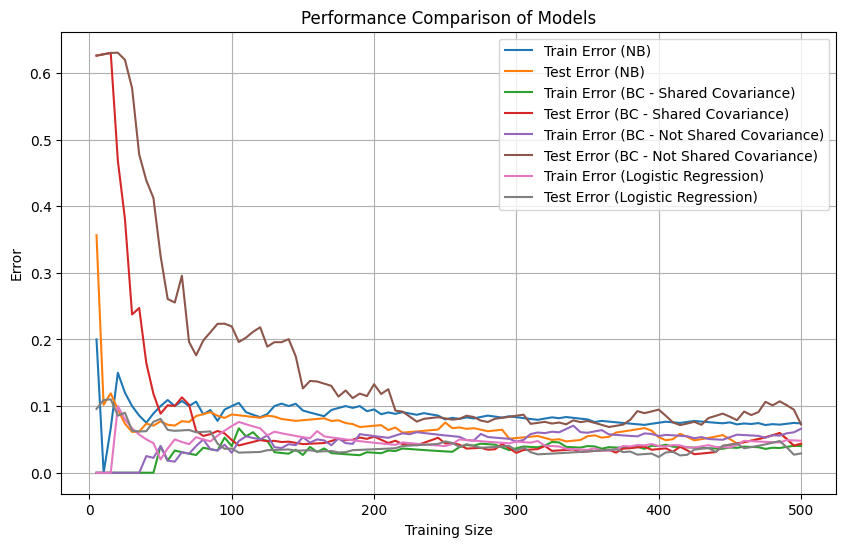

In [ ]:
# Parameters for the experiment
sample_sizes = np.arange(5, 501, 5)
num_repetitions = 10
train_errors_nb = []
test_errors_nb = []
train_errors_bc_shared = []
test_errors_bc_shared = []
train_errors_bc = []
test_errors_bc = []
train_errors_lr = []
test_errors_lr = []

# Perform the experiment
for sample_size in sample_sizes:
    train_errors_nb_rep = []
    test_errors_nb_rep = []
    train_errors_bc_shared_rep = []
    test_errors_bc_shared_rep = []
    train_errors_bc_rep = []
    test_errors_bc_rep = []
    train_errors_lr_rep = []
    test_errors_lr_rep = []

    for _ in range(num_repetitions):
        # Split the data into training and testing sets with shuffle
        X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=sample_size, shuffle=True, random_state=42)

        # Fit models
        nb.fit(X_train, y_train)
        bc_shared.fit(X_train, y_train)
        bc.fit(X_train, y_train)
        lr.fit(X_train, y_train)

        # Make predictions and calculate errors
        y_train_pred_nb = nb.predict(X_train)
        y_test_pred_nb = nb.predict(X_test)
        train_errors_nb_rep.append(1 - accuracy_score(y_train, y_train_pred_nb))
        test_errors_nb_rep.append(1 - accuracy_score(y_test, y_test_pred_nb))

        y_train_pred_bc_shared = bc_shared.predict(X_train)
        y_test_pred_bc_shared = bc_shared.predict(X_test)
        train_errors_bc_shared_rep.append(1 - accuracy_score(y_train, y_train_pred_bc_shared))
        test_errors_bc_shared_rep.append(1 - accuracy_score(y_test, y_test_pred_bc_shared))

        y_train_pred_bc = bc.predict(X_train)
        y_test_pred_bc = bc.predict(X_test)
        train_errors_bc_rep.append(1 - accuracy_score(y_train, y_train_pred_bc))
        test_errors_bc_rep.append(1 - accuracy_score(y_test, y_test_pred_bc))

        y_train_pred_lr = lr.predict(X_train)
        y_test_pred_lr = lr.predict(X_test)
        train_errors_lr_rep.append(1 - accuracy_score(y_train, y_train_pred_lr))
        test_errors_lr_rep.append(1 - accuracy_score(y_test, y_test_pred_lr))

    # Calculate mean errors for this sample size
    train_errors_nb.append(np.mean(train_errors_nb_rep))
    test_errors_nb.append(np.mean(test_errors_nb_rep))

    train_errors_bc_shared.append(np.mean(train_errors_bc_shared_rep))
    test_errors_bc_shared.append(np.mean(test_errors_bc_shared_rep))

    train_errors_bc.append(np.mean(train_errors_bc_rep))
    test_errors_bc.append(np.mean(test_errors_bc_rep))

    train_errors_lr.append(np.mean(train_errors_lr_rep))
    test_errors_lr.append(np.mean(test_errors_lr_rep))

# Task III: Create Plots

plt.figure(figsize=(10, 6))

plt.plot(sample_sizes, train_errors_nb, label='Train Error (NB)')
plt.plot(sample_sizes, test_errors_nb, label='Test Error (NB)')

plt.plot(sample_sizes, train_errors_bc_shared, label='Train Error (BC - Shared Covariance)')
plt.plot(sample_sizes, test_errors_bc_shared, label='Test Error (BC - Shared Covariance)')

plt.plot(sample_sizes, train_errors_bc, label='Train Error (BC - Not Shared Covariance)')
plt.plot(sample_sizes, test_errors_bc, label='Test Error (BC - Not Shared Covariance)')

plt.plot(sample_sizes, train_errors_lr, label='Train Error (Logistic Regression)')
plt.plot(sample_sizes, test_errors_lr, label='Test Error (Logistic Regression)')

plt.xlabel('Training Size')
plt.ylabel('Error')
plt.title('Performance Comparison of Models')
plt.legend()
plt.grid(True)
plt.show()




OBSERVATIONS:
a. The train error of all the classifiers decreases as the number of training data points is increased. This is because the models are able to learn the patterns in the data more accurately with more data. However, the test error of the Naive Bayes classifier does not decrease as much as the test errors of the other classifiers. This is because the Naive Bayes classifier makes the assumption that all the features are independent, which is not always true. As the number of training data points increases, the Naive Bayes classifier becomes more confident in its predictions, even when the features are not actually independent. This leads to overfitting, which is why the test error of the Naive Bayes classifier does not decrease as much as the test errors of the other classifiers.

The test errors of the Bayesian classifiers (Bayesian with shared covariance and Bayesian with not shared covariance) decrease at a similar rate. This is because these classifiers do not make the same independence assumption as the Naive Bayes classifier. They are able to learn the dependencies between the features, which helps them to avoid overfitting.

The test error of the logistic regression classifier decreases at a slightly slower rate than the test errors of the Bayesian classifiers. This is because the logistic regression classifier has more parameters to learn than the Bayesian classifiers. This makes it more difficult for the logistic regression classifier to avoid overfitting, but it also makes it more flexible, which can lead to better performance on the test set if the training set is large enough.

b. The Naive Bayes classifier is best suited when the training set is small. This is because it is a simple classifier that is not prone to overfitting. However, the Naive Bayes classifier is not as flexible as the other classifiers, so it may not be the best choice if the training set is large.

The Bayesian classifiers (Bayesian with shared covariance and Bayesian with not shared covariance) are best suited when the training set is medium-sized. They are more flexible than the Naive Bayes classifier, but they are not as prone to overfitting as the logistic regression classifier.

The logistic regression classifier is best suited when the training set is large. It is the most flexible classifier, but it is also the most prone to overfitting. If the training set is large enough, the logistic regression classifier can learn the patterns in the data without overfitting, which can lead to the best performance on the test set.

c. My observations can be justified by the following speculations and possible reasons:

The Naive Bayes classifier makes the assumption that all the features are independent. This assumption is not always true, but it is a good approximation in many cases. When the training set is small, the Naive Bayes classifier is able to learn the patterns in the data without overfitting, even if the assumption of independence is not strictly true.
The Bayesian classifiers (Bayesian with shared covariance and Bayesian with not shared covariance) do not make the same independence assumption as the Naive Bayes classifier. They are able to learn the dependencies between the features, which helps them to avoid overfitting. However, they are also more complex than the Naive Bayes classifier, which makes them more prone to overfitting if the training set is small.
The logistic regression classifier has more parameters to learn than the Bayesian classifiers. This makes it more difficult for the logistic regression classifier to avoid overfitting, but it also makes it more flexible, which can lead to better performance on the test set if the training set is large enough.